# Table of contents
1. [Settings](#settings)
2. [Download](#download)
3. [Preprocessing](#pre)
4. [Heat demand time series](#demand)
5. [COP time series](#cop)
6. [Writing](#write)

<a id=settings></a>
# 1. Settings

## Setup
I recommend running this notebook in a [conda environment, which can be created from the environment.yml file](https://conda.io/docs/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) provided with this notebook.

## Import Python libraries

In [3]:
# Python modules
import os
import shutil
import pandas as pd
from time import time
from datetime import date

# Custom scripts
import scripts.download as download 
import scripts.read as read
import scripts.preprocess as preprocess
import scripts.demand as demand
import scripts.cop as cop
import scripts.write as write
import scripts.metadata as metadata

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Version and changes

In [4]:
version = '2019-08-06'
changes = 'Minor revisions'

## Make directories

In [5]:
home_path = os.path.realpath('.')

input_path = os.path.join(home_path, 'input')
interim_path = os.path.join(home_path, 'interim')
output_path = os.path.join(home_path, 'output', version)

for path in [input_path, interim_path, output_path]:
    os.makedirs(path, exist_ok=True)

## Select geographical and temporal scope

In [6]:
all_countries = ['AT', 'BE'] # available
regions = read.shapes(input_path)
regions = regions.loc[regions.country_code.isin(all_countries)]

In [7]:
year_start = 2008
year_end = 2009

## Set ECMWF access key
In the following, this notebook downloads weather data from the ECMWF server. For accessing this server, follow the steps below:
1.  Register at https://apps.ecmwf.int/registration/.
2.  Login at https://apps.ecmwf.int/auth/login/.
3.  Retrieve your key at https://api.ecmwf.int/v1/key/.
4.  Enter your key and your e-mail below.

If you have already [installed](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets#AccessECMWFPublicDatasets-key) your ECMWF KEY, this step is skipped.

<a id=download></a>
# 2. Download
In the following, weather and population data is downloaded from the respective sources. For all years and countries, this takes around 45 minutes to run.

Note that standard load profile parameters from [BGW](http://www.gwb-netz.de/wa_files/05_bgw_leitfaden_lastprofile_56550.pdf)/[BDEW](https://www.enwg-veroeffentlichungen.de/badtoelz/Netze/Gasnetz/Netzbeschreibung/LF-Abwicklung-von-Standardlastprofilen-Gas-20110630-final.pdf) and energy statistics from the [EU Builidng Database](http://ec.europa.eu/energy/en/eu-buildings-database) are already provided with this notebook in the input directory.

## Weather data
As mentioned above, weather data is downloaded from ECMWF, more specifically form the [ERA-Interim](https://www.ecmwf.int/en/research/climate-reanalysis/era-interim) archive. The following data is retrieved:
* Wind: wind speed at 10 m above ground for heating seasons (October-April) in 1979-2016 in monthly resolution 
* Temperature: ambient air temperature at 2 m above ground for the selected years in six-hourly resolution 

All data is downloaded for the whole of Europe. If some data already exists on your computer, this data will be skipped in the download process.

In [12]:
download.wind(input_path)
download.temperatures(input_path, year_start, year_end)

2020-04-03 16:07:07 ECMWF API python library 1.4.2
2020-04-03 16:07:07 ECMWF API at https://api.ecmwf.int/v1
2020-04-03 16:07:08 Welcome Francesco Lombardi
2020-04-03 16:07:09 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2020-04-03 16:07:09 Request submitted
2020-04-03 16:07:09 Request id: 5e87511dffde1cabf110cbe5
2020-04-03 16:07:09 Request is submitted
2020-04-03 16:07:10 Request is queued
Calling 'nice mars /tmp/08/54/tmp-_marstXeXy9.req'
mars - WARN -
mars - WARN - From 29 January 2019 10AM (UTC) MARS uses the interpolation
mars - WARN - provided by the MIR library. For more details, see
mars - WARN - https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR
mars - WARN -
PPDIR is /var/tmp/ppdir/x86_64
mars - INFO   - 20200403.150730 - Welcome to MARS
mars - INFO   - 20200403.150730 - MARS Client bundle version: 6.27.7.1
mars - INFO   - 20200403.150730 - MARS Client package version: 6.27.7
mar

## Population data
As mentioned above, population data is downloaded from [EUROSTAT](http://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/population-distribution-demography/geostat).

In [13]:
download.population(input_path)

<a id=pre></a>
# 3. Preprocessing
Population and weather data is preprocessed. This takes around 10 minutes to run.

## Re-mapping population data
The population data from Eurostat features a 1 km² grid, which country-by-country transformed to the 0.75 x 0.75° grid of the weather data in the following. Interim results are saved/loaded from disk.

AUT_1
/Users/brynmorp/Repos/when2heat/interim/population_AUT_1 already exists and is read from disk.
AUT_2
/Users/brynmorp/Repos/when2heat/interim/population_AUT_2 already exists and is read from disk.
AUT_3
/Users/brynmorp/Repos/when2heat/interim/population_AUT_3 already exists and is read from disk.
BEL
/Users/brynmorp/Repos/when2heat/interim/population_BEL already exists and is read from disk.
Plot of the re-mapped population data of AUT_1 (first selected country) for visual inspection:


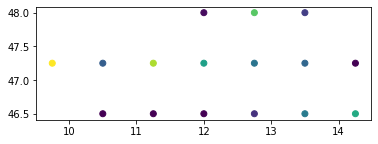

In [23]:
mapped_population = preprocess.map_population(input_path, regions, interim_path)

In [24]:
mapped_population['AUT_1']

index_right
(46.5, 10.5)          35
(46.5, 11.25)        541
(46.5, 12.0)         633
(46.5, 12.75)      51054
(46.5, 13.5)      149156
(46.5, 14.25)     218953
(47.25, 9.75)     360202
(47.25, 10.5)     106029
(47.25, 11.25)    315669
(47.25, 12.0)     203959
(47.25, 12.75)    138622
(47.25, 13.5)     118446
(47.25, 14.25)       695
(48.0, 12.0)       10504
(48.0, 12.75)     266645
(48.0, 13.5)       65051
Name: TOT_P, dtype: int64

## Preparing weather data

The temporal resolution of the weather data is changed as follows:
* Temperatures (air and soil): from six-hours to one hour
* Wind: from monthly to the average of all heating periods from 1979 to 2016

To speed up the calculation, all weather data is filtered by the selected countries.

Plot of the wind averages for visual inspection:


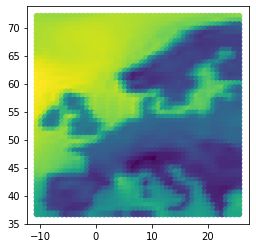

In [25]:
wind = preprocess.wind(input_path, mapped_population)

In [26]:
temperature = preprocess.temperature(input_path, year_start, year_end, mapped_population)

<a id=demand></a>
# 4. Heat demand time series
For all years and countries, the calculation of heat demand time series takes around 20 minutes to run.

## Reference temperature

To capture the thermal inertia of buildings, the daily reference temperature is calculated as the weighted mean of the ambient air temperature of the actual and the three preceding days. 

In [27]:
reference_temperature = demand.reference_temperature(temperature['air'])

## Daily demand

Daily demand factors are derived from the reference temperatures using profile functions as described in [BDEW](https://www.enwg-veroeffentlichungen.de/badtoelz/Netze/Gasnetz/Netzbeschreibung/LF-Abwicklung-von-Standardlastprofilen-Gas-20110630-final.pdf).

In [28]:
daily_parameters = read.daily_parameters(input_path)

In [29]:
daily_heat = demand.daily_heat(reference_temperature, 
                               wind, 
                               daily_parameters)

In [30]:
daily_water = demand.daily_water(reference_temperature,
                                 wind,
                                 daily_parameters)

## Hourly demand

Hourly damand factors are calculated from the daily demand based on hourly factors from [BGW](http://www.gwb-netz.de/wa_files/05_bgw_leitfaden_lastprofile_56550.pdf).

In [31]:
hourly_parameters = read.hourly_parameters(input_path)

In [32]:
hourly_heat = demand.hourly_heat(daily_heat,
                                 reference_temperature, 
                                 hourly_parameters)

In [33]:
hourly_water = demand.hourly_water(daily_water,
                                   reference_temperature, 
                                   hourly_parameters)

In [34]:
hourly_space = (hourly_heat - hourly_water).clip(lower=0)

## Weight and scale
The spatial time series are weighted with the population and normalized to 1 TWh yearly demand each. Years included in the building database are scaled accordingly. The time series not spatially aggregated yet because spatial time series are needed for COP calculation.

In [ ]:
building_database = read.building_database(input_path)

In [ ]:
spatial_space = demand.finishing(hourly_space, mapped_population, building_database['space'])

In [ ]:
spatial_water = demand.finishing(hourly_water, mapped_population, building_database['water'])

## Safepoint

The following cells can be used to save and reload the spatial hourly time series.

In [ ]:
spatial_space.to_pickle(os.path.join(interim_path, 'spatial_space'))
spatial_water.to_pickle(os.path.join(interim_path, 'spatial_water'))

In [ ]:
spatial_space = pd.read_pickle(os.path.join(interim_path, 'spatial_space'))[countries]
spatial_water = pd.read_pickle(os.path.join(interim_path, 'spatial_water'))[countries]

## Aggregate and combine
All heat demand time series are aggregated country-wise and combined into one data frame.

In [ ]:
final_heat = demand.combine(spatial_space, spatial_water)

<a id=cop></a>
# 5. COP time series
For all years and countries, the calculation of the coefficient of performance (COP) of heat pumps takes around 5 minutes to run.

## Source temperature 
For air-sourced, ground-sources and groundwater-sourced heat pumps (ASHP, GSHP and WSHP), the relevant heat source temperatures are calculated.

In [ ]:
source_temperature = cop.source_temperature(temperature)

## Sink temperatures
Heat sink temperatures, i.e. the temperature level at which the heat pumps have to provide heat, are calculated for floor heating, radiator heating and warm water.

In [ ]:
sink_temperature = cop.sink_temperature(temperature)

## COP
The COP is derived from the temperature difference between heat sources and sinks using COP curves.

In [ ]:
cop_parameters = read.cop_parameters(input_path)

In [ ]:
spatial_cop = cop.spatial_cop(source_temperature, sink_temperature, cop_parameters)

## Safepoint

The following cells can be used to save and reload the spatial hourly time series.

In [ ]:
spatial_cop.to_pickle(os.path.join(interim_path, 'spatial_cop'))

In [ ]:
spatial_cop = pd.read_pickle(os.path.join(interim_path, 'spatial_cop'))[countries]

## Aggregating and correction
The spatial COP time series are weighted with the spatial heat demand and aggregated into national time series. The national time series are corrected for part-load losses.

In [ ]:
final_cop = cop.finishing(spatial_cop, spatial_space, spatial_water)

## COP averages
COP averages (performance factors) are calculated and saved to disk for validation purposes.

In [ ]:
cop.validation(final_cop, final_heat, interim_path, 'corrected')

In [ ]:
cop.validation(cop.finishing(spatial_cop, spatial_space, spatial_water, correction=1),
               final_heat, interim_path, "uncorrected")

<a id=write></a>
# 6. Writing
For data and metadata, this takes around 5 minutes to run.

## Data
As for the OPSD "Time Series" package, data are provided in three different "shapes":

* SingleIndex (easy to read for humans, compatible with datapackage standard, small file size)
  * Fileformat: CSV, SQLite
* MultiIndex (easy to read into GAMS, not compatible with datapackage standard, small file size)
  * Fileformat: CSV, Excel
* Stacked (compatible with data package standard, large file size, many rows, too many for Excel)
  * Fileformat: CSV

The different shapes are created before they are saved to files.

In [ ]:
shaped_dfs = write.shaping(final_heat, final_cop)

Write data to an SQL-database, ...

In [ ]:
write.to_sql(shaped_dfs, output_path, home_path)

and to CSV.

In [ ]:
write.to_csv(shaped_dfs, output_path)

Writing to Excel takes extremely long. As a workaround, a copy of the multi-indexed data is writtten to CSV and manually converted to Excel.

## Metadata
The metadata is reported in a JSON file.

In [ ]:
metadata.make_json(shaped_dfs, version, changes, year_start, year_end, output_path)

## Copy input data

In [ ]:
shutil.copytree(input_path, os.path.join(output_path, 'original_data'))

## Checksums

In [ ]:
metadata.checksums(output_path, home_path)